In [66]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
from collections import namedtuple

In [67]:
Goal              = namedtuple('GOAL', ['X', 'Y'])
GOAL              = Goal(X=9, Y=9)
Start             = namedtuple('Start', ['X', 'Y'])
START             = Start(X=2, Y=1)
K_ATT             = 0.02
Obstacle          = namedtuple('Obstacle', ['X', 'Y', 'R'])
OBSTACLE1         = Obstacle(X=6, Y=4,   R=1)
OBSTACLE2         = Obstacle(X=7, Y=8,   R=.5)
OBSTACLE3         = Obstacle(X=3, Y=2.2, R=.5)
RHO_0             = 1
K_REP             = .05
MAX_REPULS_HEIGHT = .4

### Einleitung:
In dieser Aufgabe geht es darum anhand der Potentialfeldmethode einen Roboter in einer Spielwelt mit folgenden Parametern zu navigieren:

- Größe 10 x 10 mit 200 x 200 Feldern (Dimension 0.05 x 0.05)
- Startpunkt Koordinaten (2,1)
- Zielpunkt Koordinaten (9,9)
- Feldkonstante $k_{att}$ = 0.02
- Hindernis 1: Mittelpunkt (6,4), Radius = 1
- Hindernis 2: Mittelpunkt (7,8), Radius = 0.5
- Hindernis 3: Mittelpunkt (3,2.2), Radius = 0.5
- $k_{rep}$ = 0.05
- $\rho_0$ = 1

###  1) Erstellung des anziehenden Potientialfeldes:
Erste Teilaufgabe ist es das anziehende Potentialfeld ohne Hindernisse zu berechnen und darzustellen.
Dies geschiet mit folgender Formel:
$$ U_{att}(q) = \frac{1}{2} \times k_{att} \times \rho_{goal}^2(q)$$
wobei $\rho_{goal}$ den euklidischen Abstand von der Koordinate des Roboters zum Ziel beschreibt.
$$ \rho = \sqrt{(x_{Roboter} - y_{Goal})^2 + (y_{Roboter} - y_{Goal})^2} $$
Um nun das anzuziehende Potentialfeld darstellen zu können wird nun über jeden Punkt der Spielwelt $U_{att}(q)$ berechnet.

In [68]:
calc_attractive_field = lambda x, y: 0.5 * K_ATT * (np.power(x - GOAL.X, 2) + (np.power(y - GOAL.Y, 2)))

#### Plot Potentialfeld:


Hier ist das anziehende Potentialfeld ohne Hindernisse zu sehen.

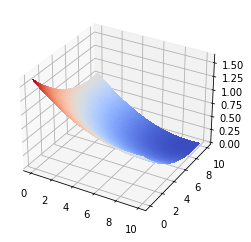

In [69]:
fig              = plt.figure()
ax               = fig.add_subplot(111, projection='3d')
x     = y        = np.arange(0, 10, 0.05)
X, Y             = np.meshgrid(x, y)
attracting_field = np.array(calc_attractive_field(np.ravel(X), np.ravel(Y)))
Z                = attracting_field.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0.5, antialiased=False)

plt.show()

### 2) Berechnung des abstoßenden Potentialfeldes:
Ähnlich wie bei der ersten Aufgabe wurde das abstoßende Potentialfeld isoliert berechnet und dargestellt. Das abstoßende Feld $U_{rep}$ lässt sich folgendermaßen berechnen.
$$U_{rep}(q) = \begin{cases}
\frac{1}{2} \times k_{rep} \times (\frac{1}{\rho(q)} - \frac{1}{\rho_0})^2 & \rho(q) < \rho_0 \\
0 & \, \rho(q) \geq \rho_0
\end{cases}$$
Eine wesentliche Komponente dieser Formel ist $\rho(q)$ welches den euklidischen Abstand vom Roboterpunkt zu einem Hindernis berechnet. Hierbei sollte beachtet werden, dass in diesem Fall der euklidische Abstand der Strecke entspricht die der Roboter auch fahren kann. Da das Hinderniss den Roboter abstößt ist diesem nur möglich bis zum Rand des Hindernisses zu fahren, weshalb es notwendig ist vom Abstand den Radius des Hindernisses abzuziehen.
$$ \rho(q) = \sqrt{(x - x_{obs})^2 + (y - y_{obs})^2} - Radius_{obs} $$
Das resultierende abstoßenden Potentialfeld entspricht der Summe aller einzelner Potentialfelder. D.h für diese Teilaufgabe wird über jeden Punkt des Spielfeldes ein abstoßendes Potentialfeld für je ein Hindernis berechnet. Anschließen wurden die drei abstoßenden Potentialfelder aufsummiert.

In [70]:
def calc_rho_q(x, y, obstacle):
    return np.sqrt(np.power((x - obstacle.X),2) + np.power((y - obstacle.Y),2)) - obstacle.R

rho_q_obstacle1 = calc_rho_q(np.ravel(X), np.ravel(Y), OBSTACLE1)
rho_q_obstacle2 = calc_rho_q(np.ravel(X), np.ravel(Y), OBSTACLE2)
rho_q_obstacle3 = calc_rho_q(np.ravel(X), np.ravel(Y), OBSTACLE3)

In [71]:
def calc_repulsiv_field(rho_q_obstacle, rho_0, krep):
    rep_field = []
    result = 0.0
    for rho_q in rho_q_obstacle:
        result = 0.5 * krep * (1/rho_q - 1/rho_0)**2 if rho_q < rho_0 and rho_q != 0 else 0
        rep_field.append(result)
    return np.array(rep_field)
    
repulsiv_field_obstacle1 = calc_repulsiv_field(rho_q_obstacle1, RHO_0, K_REP)
repulsiv_field_obstacle2 = calc_repulsiv_field(rho_q_obstacle2, RHO_0, K_REP)
repulsiv_field_obstacle3 = calc_repulsiv_field(rho_q_obstacle3, RHO_0, K_REP)

total_repulsiv_field = repulsiv_field_obstacle1 + repulsiv_field_obstacle2 + repulsiv_field_obstacle3
total_repulsiv_field = np.where(total_repulsiv_field > MAX_REPULS_HEIGHT, MAX_REPULS_HEIGHT, total_repulsiv_field)

#### Plot abstoßendes Potentialfeld:

Hier ist nun das resultierende abstoßendes Potentialfeld

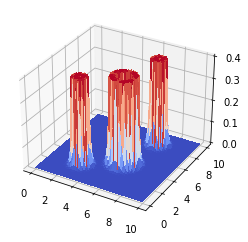

In [72]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
Z       = total_repulsiv_field.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0.5, antialiased=False)

plt.show()

### 3) Plot resultierendes Potentialfeld:
Das resultierende Potentialfeld ist nun die Summe des anziehenden und des abstoßenden Potentialfeldes.

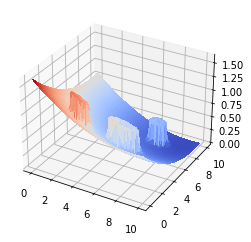

In [73]:
total_potential_field = attracting_field + total_repulsiv_field

fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
Z       = total_potential_field.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0.5, antialiased=False)

plt.show()

### 4) Berechnung der anziehende Kraft und Darstellung des Roboterpfades:
Die punktuell wirkende anziehende Kraft entspricht dem Gradienten des anziehenden Feldes.
$$F_{att}(q) = -\nabla U_{att}(q) = -k_{att} \times (q-q_{goal})$$
Da der Gradient einer Funktion in Richtung der höchsten Steigung zeigt, muss in unserem Fall der negative Gradient genommen werden weil der Startpunkt das höchste Potential und das Ziel das niedrigste Potential hat. Hier wird prinzipiell die Kraft berechnet die auf den Roboter wirkt welcher auf einem bestimmten Punkt des Pfades zum Zielpunkt ist.

In [74]:
calc_attractive_force = lambda cur_pos, goal: np.array(-K_ATT * (cur_pos - goal)) 

### Berechnung abstoßende Kraft:
Ähnlich wie bei der anziehenden Kraft ist die abstoßende Kraft der negative Gradient des abstoßenden Feldes.
$$ F_{rep}(q) = -\nabla U_{rep}(q) = \begin{cases}
k_{rep} \times (\frac{1}{\rho(q)} - \frac{1}{\rho_0}) \times \frac{q - q_{obstacle}}{\rho^3(q)} & \rho(q) < \rho_0 \\
0 & \, \rho(q) \geq \rho_0
\end{cases}$$
Hier wird die abstoßende punktuelle Kraft im Bezug zu den drei Hindernissen berechnet (Summenbildung).

In [75]:
RADIUS = -1

def calc_repulsiv_force(cur_pos, krep, obstacles, rho_0):
    force = np.array([0.0, 0.0])
    
    calc_rho_q              = lambda rob_pos, obstacle_pos: np.linalg.norm(rob_pos - obstacle_pos[:2]) - \
                                                            obstacle_pos[RADIUS]
    
    calc_delta_q_q_obstacle = lambda rob_pos, obstacle_pos: rob_pos - obstacle_pos

    for obstacle in obstacles:
        force += krep * ((1/calc_rho_q(cur_pos, obstacle)) - (1/rho_0)) * \
                         calc_delta_q_q_obstacle(cur_pos, obstacle[:2]) / \
                         calc_rho_q(cur_pos, obstacle)**3 if calc_rho_q(cur_pos, obstacle) < rho_0 else 0
    return force

### Berechnung resultierende Kraft:
Die resultierende Kraft ist nun die Summe aller anstoßenden und abstoßenden Kräften welche dem Pfad entspricht.

In [76]:
goal        = np.array([GOAL.X, GOAL.Y])
robot_pos   = np.array([START.X, START.Y])
obstacles   = np.array([OBSTACLE1, OBSTACLE2, OBSTACLE3])
positions_x = np.array([START.X])
positions_y = np.array([START.Y])


while True:
    cur_pos = robot_pos
    robot_pos = robot_pos + \
                calc_attractive_force(cur_pos, goal) + \
                calc_repulsiv_force(cur_pos, K_REP, obstacles, RHO_0)
    
    positions_x = np.append(positions_x, robot_pos[0])
    positions_y = np.append(positions_y, robot_pos[1])
    if np.linalg.norm(np.subtract(robot_pos, goal)) < 1e-5:
        break

#### Plot Roboterpfad:
Hier der Pfad des Roboters zu sehen, der Roboter beginnt bei dem Startpunkt bei (2,1) und endet beim Ziel (9,9) wobei die ausgefüllten Kreise die Hindernisse darstellen.

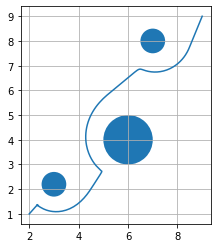

In [78]:
obstacle1 = plt.Circle((OBSTACLE1.X, OBSTACLE1.Y), OBSTACLE1.R)
obstacle2 = plt.Circle((OBSTACLE2.X, OBSTACLE2.Y), OBSTACLE2.R)
obstacle3 = plt.Circle((OBSTACLE3.X, OBSTACLE3.Y), OBSTACLE3.R)

fig, ax = plt.subplots()
ax.add_patch(obstacle1)
ax.add_patch(obstacle2)
ax.add_patch(obstacle3)

plt.plot(positions_x, positions_y)
plt.gca().set_aspect('equal')
plt.grid()
plt.show()